# Machine Learning Coursework 

For the coursework, please make sure to implement your own code and not use libraries (except where explicitly asked). You will need to present your own code that performs nested cross-validation and the k-nearest neighbour algorithm, build confusion matrices, and estimate distances between data samples.

The purpose of this coursework is to help you:
- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python  
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:
- don't use libraries that implement kNN or cross-validation.  We want to see your code!
- Remember to comment all of your code (see here for tips: https://stackabuse.com/commenting-python-code/). You can also make use of Jupyter Markdown, where appropriate, to improve the layout of your code and documentation.
- Please add docstrings to all of your functions (so that users can get information on inputs/outputs and what each function does by typing SHIFT+TAB over the function name. For more detail on python docstrings, see here: https://numpydoc.readthedocs.io/en/latest/format.html)
- When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook. 
- Always save your notebook when you are done (this is not automatic)!
- Upload your completed notebook using the VLE

Plagiarism: please make sure that the material you submit has been created by you. Any sources you use for code should be properly referenced. Your code will be checked for plagiarism using appropriate software.

### Marking 

The grades in this coursework are allocated approximately as follows:

|                                                    | mark  |  
|----------------------------------------------------|-------|
| Data exploration (+ 2 questions)                   | 9     |  
| Code, docu. & comments (KNN + Evaluation + NCV)    | 12    |  
| Results (KNN folds + Summary + Confusion matrices) | 9     |  
| Final questions:                                   | 9     |  
| Overall quality & use of Markdown                  | 6     |  
| Total available                                    |**45** |  


## 1. Exploratory Data Analysis [9 pts]

Load the wine dataset and set up required Python packages

In [1]:
# Set matplotlib backend to inline
%matplotlib inline 

# Import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

# Load wine dataset
wine=datasets.load_wine()

# This dataset has 13 features, we will only choose a subset of these
#df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
#selected_features = ['alcohol','flavanoids','color_intensity','ash']

# Extract the data as numpy arrays of features, X, and target, y
#X = df_wine[selected_features].values
#y = wine.target

### 1.1 Understand the data via its meta data

In [ ]:
#print(wine.DESCR)

Key take outs from output:
- 178 cases
- 12 features (all numeric) and 1 target (='Hue') 
- No missing values
- Hue has 3 classes: class_0 (59 cases), class_1 (71 cases), class_2 (48 cases)
- Source: UCI ML Wine recognition datasets, UCI, 2021 (https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data)

### 1.2. Visualising the data

Visualizing the distributions of selected features and their interactions indicates if discrimination exists and thus if a good classification model could be built. From the plots below we can see:
  - Noticeable differences in the distribution of each feature by class of wine (diagonal plots) except for 'ash' which has similar central tendency for each class of wine
  - The 2D interaction plots show classes of wine differ for noticeably for some combinations of features e.g. when considering alcohol and flavanoids the three classes nearly occupy three different spaces. Whereas when considering 'ash' the interactions do not discriminate all 3 classes of wine so clearly

In [37]:
# Define plotting function

def myplotGrid(df,target,title):
    plot=sns.pairplot(df, hue=target, markers=["o", "s", "D"])
    title=plot.fig.suptitle(title, size=18, y=1.05)
    return plot

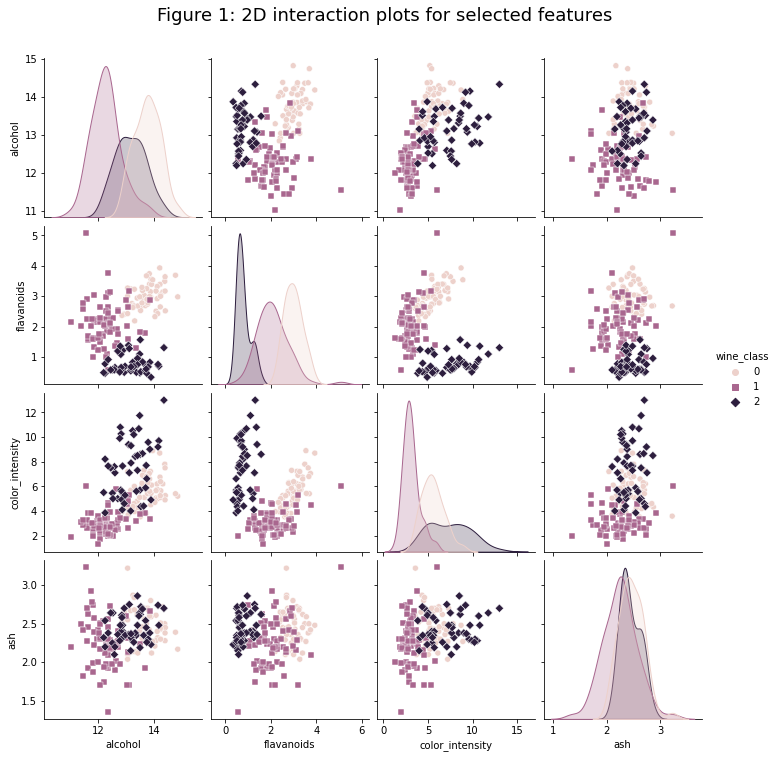

In [45]:
# Prepare the data so that Seaborn pairplot is using a dataframe

df_feats = pd.DataFrame(wine.data, columns=wine.feature_names)[['alcohol','flavanoids','color_intensity','ash']]
df_target = pd.DataFrame(wine.target).rename(columns={0:'wine_class'})
df=pd.merge(df_feats, df_target, left_index=True, right_index=True)

# Call plotting function

title="Figure 1: 2D interaction plots for selected features"
myplotGrid(df,'wine_class',title)

### 1.3. Exploratory Data Analysis under noise

Perturbing the training data with some random noise to reflect real world challenges and applying the exploratory data analysis function created above shows same patterns hold but with some apparent variation, namely greater dispersion of data points 

In [46]:
# Add noise to each observation of each feature by drawing values randomly from a normal distribution with mean=0 and sd=0.5

seed=12345
np.random.seed(seed) 
df_feats_noise=df_feats+np.random.normal(0, 0.5, df_feats.shape)
df_noise=pd.merge(df_feats_noise, df_target, left_index=True, right_index=True)

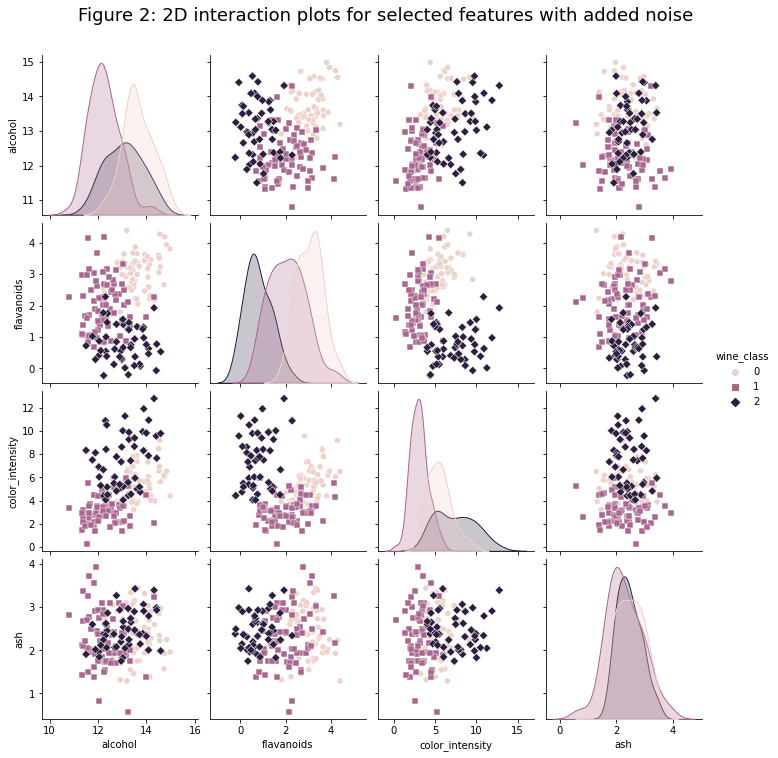

In [47]:
# Call plotting function

title="Figure 2: 2D interaction plots for selected features with added noise"
myplotGrid(df_noise,'wine_class',title)


### Q1. Exploratory data analysis
Based on your exploratory analysis, if you were to build a classifier using only two of the available features, which ones would you choose and why?  Answer as fully as you can. 


###### Answer:

Based on the plots above I would use flavanoids and alcohol to build a two feature classification model as:

- The distributions of these two features (diagonal plots in Figure 1) are the most separated in terms of the location of   their centres so alone these features discriminate well the three classes of wine
- The interaction plots for these two features show the greatest separation in terms of 2D distances whcih would lend best to a classifier based on a distance measure

    


### Q2. Data with noise
What do you observe by plotting the data without noise compared to plotting with added Gaussian noise? 


##### Answer:

As the noise is random and based on 0.5 standard deviations from a mean of zero some data points are increase in size while others decrease as a result we can see from Figure 2 that:
- The distributions for each feature (the plots on the diagonal) have altered with greater spread, most notably for 'ash' 
- As a result the separations in the 2D interaction graphs are no longer as clear as they were in Figure 1 with data points appearing more spread out

## 2. Implementing kNN [6 pts]

In the cell below, develop your own code for performing k-Nearest Neighbour classification.  You may use the scikit-learn k-NN implementation from the labs as a guide - and as a way of verifying your results - but it is important that your implementation does not use any libraries other than the basic numpy and matplotlib functions. 

Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

Hint: it helps to break the problem into various sub-problems, implemented as helper function. For example, you might want to implement separate function(s) for calculating the distances between two vectors. And another function that uncovers the nearest neighbour(s) to a given vector. 


In [ ]:
# helper code


In [ ]:
# mykNN code


## 3. Classifier evaluation [3 pts]

In the cell below, implement your own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy. 

Write some additional code that lets you display the output of your confusion matrices in a useful and easy-to-read manner.

You might want to test your functions on some test data, and compare the results to the sklearn library versions. 


In [ ]:
# confusion matrix, accuracy, precision, recall, etc. 


In [ ]:
# test evaluation code



## 4. Nested Cross-validation using your implementation of KNN  [6 pts]

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. You must write your own code -- the scikit-learn module may only be used for verification purposes. 

Your code for nested cross-validation should invoke your kNN function (see above). You cross validation function should be invoked similary to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan',...]`` evaluates the distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on both your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should evaluate **at least** two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each **fold**, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [ ]:
# parameters for testing code
nFolds = 5
np.random.seed(mySeed)

# Creates an array of random permutation of indices between 0 and the length of the X data.
# The indices are then split up into (folds) folds
indices = np.random.permutation(np.arange(0,len(X),1))
indices = np.array_split(indices, nFolds)


In [ ]:
# myNestedCrossVal code

for iFold in range(0,nFolds):
    testFold = indices[iFold]
    print('new iterration')
    
    remaining_folds = np.delete(range(0,nFolds), iFold)
    validationFold = indices[ remaining_folds[0] ]


In [ ]:
# evaluate clean data code


In [ ]:
# evaluate noisy  data code


## 5. Summary of results [6 pts]

Using your results from above, fill out the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .?  |  ? | ?  |
| 2 | .?  |  ? | ?  |
| 3 | .?  |  ? | ?  |
| 4 | .?  |  ? | ?  |
| 5 | .?  |  ? | ?  |
| **total** | .? $\pm$ ? |   |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .?  |  ? | ?  |
| 2 | .?  |  ? | ?  |
| 3 | .?  |  ? | ?  |
| 4 | .?  |  ? | ?  |
| 5 | .?  |  ? | ?  |
| **total** | .? $\pm$ ? |   |    |


### 5.2. Confusion matrix summary

Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data). You might want to adapt your ```myNestedCrossVal``` code above to also return a list of confusion matrices.

Use or adapt your evaluation code above to print the two confusion matrices below. Make sure you label the matrix rows and columns. You might also want ot show class-relative precision and recall. 


In [ ]:
print('CLEAN')
# clean data summary results



print('NOISY')
# clean data summary results


## 6. More questions [9 pts]

Now answer the following questions as fully as you can. The answers should be based on your implementation above. Write your answers in the Markdown cells below each question.



### Q3.	 Influence of noise
Do the best parameters change when noise is added to the data? Can you say that one parameter choice is better regardless of the data used? 


Answer:


### Q4. Tie break
Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.

Answer:



### Q5.	Beyond Wine 
If you were to run your k-nn algorithm on a new dataset (e.g., the breast cancer dataset, or Iris), what considerations would you need to take into consideration? Outline any changes that might be needed to your code. 


Answer:

